In [21]:
%%html
<a href=http://nbviewer.jupyter.org/github/kutvonenaki/Tokyo-traveltimes-MDS/blob/master/Tokyo%20traveltimes%20MDS.ipynb">http://nbviewer.jupyter.org/github/kutvonenaki/Tokyo-traveltimes-MDS/blob/master/Tokyo%20traveltimes%20MDS.ipynb</a>

In [2]:
import csv
import folium
import googlemaps
from datetime import datetime
import numpy as np

#input csc files, where the points are collected
#use for example http://www.findlatitudeandlongitude.com/click-lat-lng-list/ to make a list of points

#Read input locations-----------------------

inputfile=open('tokyomap_points.csv','r')
reader=csv.reader(inputfile)

latlongs=[]
placenames=[]

for row in list(reader)[1:]:
    latlongs.append([float(row[0]),float(row[1])])
    placenames.append(row[2])

In [3]:
# Show locations on map
numplaces=10 # show the ones inside tokyo only

tokyomap = folium.Map(location=[35.678842, 139.788199], tiles='OpenStreetMap',
                    zoom_start=11)
for place in range(numplaces):
    folium.Marker(latlongs[place], popup=placenames[place]).add_to(tokyomap)

tokyomap
tokyomap.save('osm.html')


In [7]:
from IPython.display import IFrame
IFrame('osm.html', width=700, height=350)

In [59]:
#Use google maps distance matrix api to do search on the travel times
#create API client
gmaps = googlemaps.Client(key='Muuta_AIzaSyAApDXJIF5XRdmfR6TnAANIY2HAue3G4xU') 
now=datetime.now()
#do a search with using local transit modes between the points shown in the above map
origins=latlongs[0:numplaces] #latlongs
destinations=latlongs[0:numplaces] #latlongs

#Do searc on google distance matrix, here mode="transit" should give the values using public transportation
distances_opt=gmaps.distance_matrix(origins,destinations, mode="driving",traffic_model="optimistic", departure_time=now)
distances_pess=gmaps.distance_matrix(origins,destinations, mode="driving",traffic_model="pessimistic", departure_time=now)


In [4]:
#print traveltimes
import plotly
from plotly.tools import FigureFactory as FF
import plotly.plotly as py

#make namelists for the tables
dist_matrix_opt=np.zeros((numplaces,numplaces))
dist_matrix_opt_text=np.zeros((numplaces,numplaces),dtype='object')
dist_matrix_pess=np.zeros((numplaces,numplaces))
dist_matrix_pess_text=np.zeros((numplaces,numplaces),dtype='object')
    
    
#read from the google API outputs
for i in range(numplaces):
    for j in range(numplaces):       
        if i==j:
            dist_matrix_opt_text[i,j]="-"
            dist_matrix_pess_text[i,j]="-"
            dist_matrix_opt[i,j]=0
            dist_matrix_pess[i,j]=0
        
        else:
            dist_matrix_opt[i,j]=distances_opt['rows'][i]['elements'][j]['duration_in_traffic']['value']
            dist_matrix_opt_text[i,j]=distances_opt['rows'][i]['elements'][j]['duration_in_traffic']['text']
        
            dist_matrix_pess[i,j]=distances_pess['rows'][i]['elements'][j]['duration_in_traffic']['value']
            dist_matrix_pess_text[i,j]=distances_pess['rows'][i]['elements'][j]['duration_in_traffic']['text']
        
        
#print tables with plotply
plotly.tools.set_credentials_file(username='salaninja', api_key='6QZFVnjhKGUFgfx14C8i')

namelist_opt=np.zeros((numplaces+1,numplaces+1),dtype='object')
namelist_opt[0,0]="Location"
namelist_pess=np.zeros((numplaces+1,numplaces+1),dtype='object')
namelist_pess[0,0]="Location"

for i in range(numplaces):
    namelist_opt[0,i+1]=placenames[i]
    namelist_opt[i+1,0]=placenames[i]
    namelist_pess[0,i+1]=placenames[i]
    namelist_pess[i+1,0]=placenames[i]

    for j in range (numplaces):
            namelist_opt[i+1,j+1]=dist_matrix_opt_text[i][j]
            namelist_pess[i+1,j+1]=dist_matrix_pess_text[i][j]

table_opt = FF.create_table(namelist_opt)
py.iplot(table_opt, filename='Driving times without traffic')


In [5]:
#print also the rush hour times

table_pess = FF.create_table(namelist_pess)
py.iplot(table_pess, filename='Driving times in rush hour')

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~salaninja/0 or inside your plot.ly account where it is named 'Driving times in rush hour'


<IPython.core.display.Javascript object>


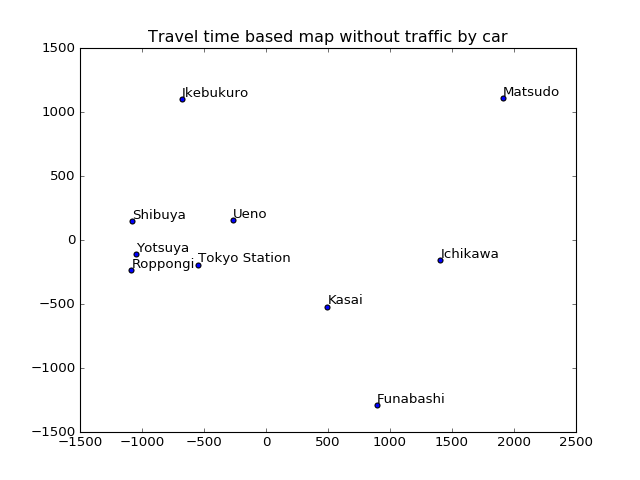

<IPython.core.display.Javascript object>


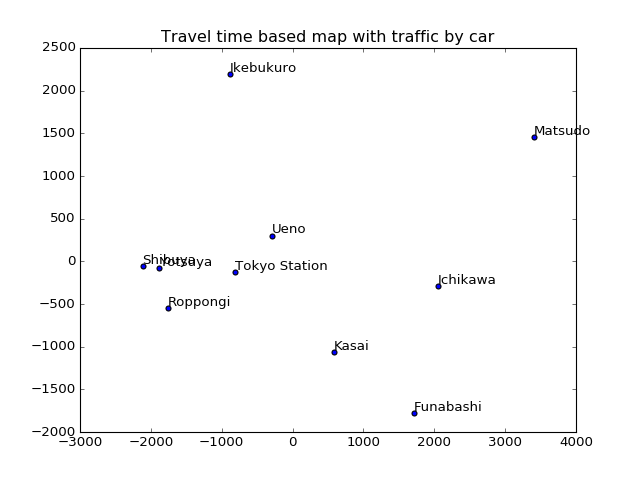

In [48]:
# perform the MDS analysis for the distance matrix

import matplotlib.pyplot as plt
%matplotlib notebook

#First of all, the distances should be symmetric, how ever driving routes are not
#(time from A to B might be different than from B to A). Here we just take the average to symmetrice

for i in range(N):
    for j in range(i,N):
        dist_matrix_opt[i,j]=(dist_matrix_opt[i,j]+dist_matrix_opt[j,i])/2
        dist_matrix_opt[j,i]=dist_matrix_opt[i,j]
        dist_matrix_pess[i,j]=(dist_matrix_pess[i,j]+dist_matrix_pess[j,i])/2
        dist_matrix_pess[j,i]=dist_matrix_pess[i,j]
        
#calculate the elements B_rs= sum_i^d x^r_i x^r_i (the cross terms)
#as in standard MDS:
def MDS(distance_matrix):
    ds2=np.square(distance_matrix)
    N=numplaces
    B=np.zeros((N,N))
    #the new coordinates
    XY=np.zeros((N,2))

    #elements
    d2_is=np.sum(ds2,axis=0)/N
    d2_ri=np.sum(ds2,axis=1)/N
    d2_ii=np.sum(ds2)/(N*N)

    #calculate the elements of B
    for i in range(N):
        for j in range(N):
            B[i,j]=0.5*(d2_is[i]+d2_ri[j]-d2_ii-ds2[i,j])

    #since B is X X^T, the point of MDS is to approximate X=CD^(1/2) by diagonalizing B
    B_evalues, C= np.linalg.eigh(B)

    #like in feature embedding, the new coordinates in dim k=2 are
    #given by the two biggest eigenvalues and their eigenvectors
    for i in range(N):
        XY[i,0]=C[i,N-1]*np.sqrt(B_evalues[N-1])
        XY[i,1]=C[i,N-2]*np.sqrt(B_evalues[N-2])
        
    return XY

#calculate for optimal and pessimistic travel times
XY_opt=MDS(dist_matrix_opt)
XY_pess=MDS(dist_matrix_pess)
    
#Plot the graph
plt.figure(1)
plt.scatter(XY_opt[:,0],XY_opt[:,1])
for i in range(N):
    plt.annotate(placenames[i], XY_opt[i,:],xytext=(0,2),textcoords = 'offset points')
plt.title('Travel time based map without traffic by car')
plt.show()

plt.figure(2)
plt.scatter(XY_pess[:,0],XY_pess[:,1])
for i in range(N):
    plt.annotate(placenames[i], XY_pess[i,:],xytext=(0,2),textcoords = 'offset points')
plt.title('Travel time based map with traffic by car')
plt.show()
